In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.colors
import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture  # GMM模型引入
from sklearn.model_selection import train_test_split

In [3]:
# 解决中文显示问题
mpl.rcParams['font.sans-serif'] = [u'SimHei']
mpl.rcParams['axes.unicode_minus'] = False

In [4]:
%matplotlib inline

In [5]:
## 数据加载
data = pd.read_csv('datas/HeightWeight.csv')
print ("数据样本数量:%d, 特征数量:%d" % data.shape)
data_x = data[data.columns[1:]]
data_y = data[data.columns[0]]
data.head()

数据样本数量:114, 特征数量:3


,Sex,Height(cm),Weight(kg)
0,0,156.0,50.0
1,0,160.0,60.0
2,0,162.0,54.0
3,0,162.0,55.0
4,0,160.5,56.0


In [7]:
## 数据分割
x, x_test, y, y_test = train_test_split(data_x, data_y, train_size=0.6, random_state=0)

In [8]:
## 模型创建及训练
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=28)
gmm.fit(x, y)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=28, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [9]:
## 模型相关参数输出
print ('均值 = \n', gmm.means_)
print ('方差 = \n', gmm.covariances_)

均值 = 
 [[173.50243688  65.03359308]
 [160.13983374  55.93370575]]
方差 = 
 [[[ 23.22794989  28.48688647]
  [ 28.48688647 105.81824734]]

 [[ 18.82128194  12.30370549]
  [ 12.30370549  31.23596113]]]


In [10]:
## 获取推测值及计算准确率

# 获取预测值
y_hat = gmm.predict(x)
y_test_hat = gmm.predict(x_test)

# 查看一下类别是否需要更改一下
change = (gmm.means_[0][0] > gmm.means_[1][0])
if change:
    z = y_hat == 0
    y_hat[z] = 1
    y_hat[~z] = 0
    z = y_test_hat == 0
    y_test_hat[z] = 1
    y_test_hat[~z] = 0

# 计算准确率
acc = np.mean(y_hat.ravel() == y.ravel())
acc_test = np.mean(y_test_hat.ravel() == y_test.ravel())
acc_str = u'训练集准确率：%.2f%%' % (acc * 100)
acc_test_str = u'测试集准确率：%.2f%%' % (acc_test * 100)
print (acc_str)
print (acc_test_str)

训练集准确率：77.94%
测试集准确率：82.61%


预测概率:
 [[1.93708432e-06 9.99998063e-01]
 [1.86096898e-06 9.99998139e-01]
 [1.78850013e-06 9.99998211e-01]
 ...
 [1.00000000e+00 9.76068785e-12]
 [1.00000000e+00 8.93577443e-12]
 [1.00000000e+00 8.17757876e-12]]


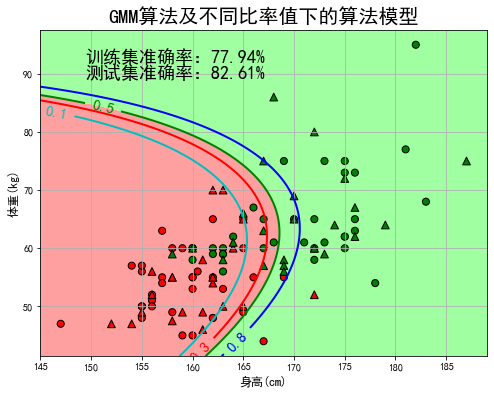

In [13]:
## 画图
cm_light = mpl.colors.ListedColormap(['#FFA0A0', '#A0FFA0'])
cm_dark = mpl.colors.ListedColormap(['r', 'g'])

# 获取数据的最大值和最小值
x1_min, x2_min = np.min(data_x)
x1_max, x2_max = np.max(data_x)
x1_d = (x1_max - x1_min) * 0.05
x1_min -= x1_d
x1_max += x1_d
x2_d = (x2_max - x2_min) * 0.05
x2_min -= x2_d
x2_max += x2_d

# 获取网格预测数据 用以后续图中色彩绘制
x1, x2 = np.mgrid[x1_min:x1_max:500j, x2_min:x2_max:500j]
grid_test = np.stack((x1.flat, x2.flat), axis=1)
grid_hat = gmm.predict(grid_test)
grid_hat = grid_hat.reshape(x1.shape)
# 如果预测的结果需要进行更改
if change:
    z = grid_hat == 0
    grid_hat[z] = 1
    grid_hat[~z] = 0

# 画图开始
plt.figure(figsize=(8, 6), facecolor='w')

# 画区域图
plt.pcolormesh(x1, x2, grid_hat, cmap=cm_light)

# 画点图 绘制原始数据，o为训练集数据，△为测试集数据
plt.scatter(x[x.columns[0]], x[x.columns[1]], s=50, c=y, marker='o', cmap=cm_dark, edgecolors='k')
plt.scatter(x_test[x_test.columns[0]], x_test[x_test.columns[1]], s=60, c=y_test, marker='^', cmap=cm_dark, edgecolors='k')

# 获取预测概率
aaa = gmm.predict_proba(grid_test)
print ("预测概率:\n", aaa)
p = aaa[:, 0].reshape(x1.shape)
# 根据概率画出曲线图（画出不同概率情况下的预测结果值）
CS = plt.contour(x1, x2, p, levels=(0.1, 0.3, 0.5, 0.8), colors=list('crgb'), linewidths=2)
plt.clabel(CS, fontsize=15, fmt='%.1f', inline=True)

# 设置值
ax1_min, ax1_max, ax2_min, ax2_max = plt.axis()
xx = 0.9*ax1_min + 0.1*ax1_max
yy = 0.1*ax2_min + 0.9*ax2_max
plt.text(xx, yy, acc_str, fontsize=18)
yy = 0.15*ax2_min + 0.85*ax2_max
plt.text(xx, yy, acc_test_str, fontsize=18)

# 设置范围及标签
plt.xlim((x1_min, x1_max))
plt.ylim((x2_min, x2_max))
plt.xlabel(u'身高(cm)', fontsize='large')
plt.ylabel(u'体重(kg)', fontsize='large')
plt.title(u'GMM算法及不同比率值下的算法模型', fontsize=20)
plt.grid()
plt.show()